Structuring math explanations

- Be aware of the layers of abstraction that are relevant to your topic
- Very concrete, under a symbolic layer
- You should understand how the symbols relate to the actual case
- And why the rules we apply to the symbols in this layer makes sense in the concrete case.
- Structure your explanation to go from the concrete to the abstract

1. Concrete before abstract
1. The topic (content) trumps production quality > zero effort
1. Choose something more esoteric/specific/niche that you'd be inclined to - be niche - (perceived nicheness > actual nicheness)
1. Know your genre
1. Definitions are not the beginning 


Nikola Jupyter posts. I'm pretty sure the thing rendering a notebook is just looking at notebook source. That is, dependencies referenced in the notebook are not required.


> Calculate a current transformer's knee point voltage algorithmically

Current transformers are used to measure current flowing in power systems. Ideally, current flowing in a current transformer's secondary winding is proportional to the primary current. 

A current transformer operates according to the principles of electromagnetic induction: 

- current flowing in the primary winding has an associated magnetic field
- the magnetic field is concentrated in the magnetic core (made typically of silicon steel)
- the secondary winding is wound around the magnetic core
- as the primary current and magnetic field are time-varying, so is the magnetic flux through the surface enclosed by the secondary coil
- the changing magnetic flux induces an electromotive force (emf) in the secondary coil
- current flows when the secondary coil forms part of a circuit

- CTs are constructed such that their approximates some ratio over some range of current 
The physical properties of the core, including its size, limits the transformation.


- this doesn't hold for all circumstances. 
- CT cores saturate. 
- Linear relationship
- 


process of saturation
  magnetic field strength go up
  flux follows to a point
  at some point increase in field strenght does not result in proportional flux increase
  secondary sees non-linear induced voltage
  saturation

error, not ideal

want to operate somewhat within accurate range

an increase in 

The knee point voltage of a current transformer (CT) is an important property to consider in the design of power system protection schemes, where (asymmetric) fault currents can be many times rated current.

- operate in linear zone.
- measure knee point
- adjust secondary voltage, measure current
- becaues these values are proportional to other values: voltage to and current proportional to magnetic field strength

The knee point is the point along a excitiation curve, above which voltage is no longer linear with respect to exciting current. The IEC defines the knee point voltage as the voltage at which a 10% increase in applied voltage results in a 50% increase in exciting current [#]_.

You can use injection test equipment to automatically determine a CT's knee point voltage.


- Test equipment that adjusts voltage and measure magnetising current.

$\frac{V(1.5 I)}{V(I)} = 1.1$


.. [#] https://www.electropedia.org/iev/iev.nsf/display?openform&ievref=321-02-34


## Test data

- adjust voltage, measure current
- equipment can zero in on knee point automatically
- does this by iteratively testing values - needs expanding

- Sometimes you're working with a scanned test report from the 1980s with a table of test data
- It would be nice to determine the knee point algorithmically rather than "eyeballing it".

We've got magnetisation current and voltage data obtained from testing. Test units inject known amounts of current on one side of the winding, with the other shorted. - no that's probably not right. A circuit would be created with the secondary coil and voltage (or current) source.

Let's take a look at data from a test report. Here, current and voltage measurements are represented in Python as [tuples](https://docs.python.org/3.8/library/stdtypes.html#typesseq-tuple).

- RMS is root mean square, a way to represent a time-varying value as a scalar

In [99]:
# EAAY C196 data 2S1-2S5
i = 0.01, 0.02, 0.04, 0.08, 0.2, 0.5, 1.0, 2.0
v = 175, 440, 800, 925, 970, 990, 1020, 1050

Let's visualise the data.

In [12]:
from matplotlib import pyplot

Text(0.5, 1.0, 'Test Data')

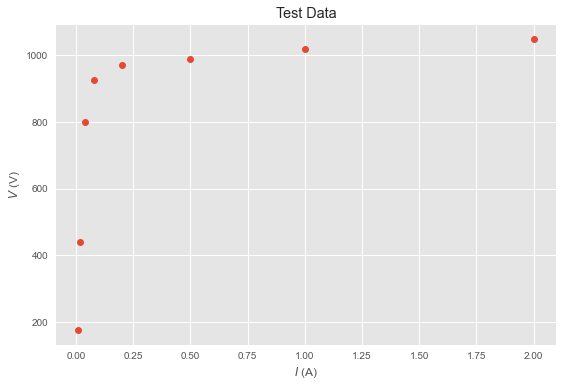

In [109]:
# Chart styles
pyplot.style.use('ggplot')
# pyplot.style.use('seaborn')
# pyplot.style.use('seaborn-notebook')
# pyplot.style.use('fivethirtyeight')

pyplot.plot(i, v, 'o')
# Exciting current (RMS)
pyplot.xlabel('$I$ (A)')
# Injection voltage (RMS)
pyplot.ylabel('$V$ (V)')
pyplot.title('Test Data')

# Modeling

We want a continuous function that approximates this data. We want to fit a *model* to this data. 

[This paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9031356) covers some established simple models:

for approximation of the initial B-H curve. The B-H curve is proportional to our I-V curve.

- Froelich's equation $ V(I) = \frac{I}{a + b \cdot I} $
- Inverse tangent $ V(I) = a \cdot \tan^{-1}(b \cdot I) $

To each of these I added a parameter $c$ that controls horizontal translation of the model. 

- Froelich's equation $ V(I) = \frac{(I - c)}{a + b \cdot (I - c)} $
- Inverse tangent $ V(I) = a \cdot \tan^{-1}(b \cdot (I - c)) $


Implement the mathematical function as a Python function.

In [111]:
# Froelich's equation.
f = lambda x, a, b, c: (x - c) / (a + b * (x - c))

I used SciPy's [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit) function.


- `curve_fit` returns values of parameters that best fit a function to given data. 
- By default, there are no bounds on parameter values.
- We can "help" `curve_fit` by providing bounds.
- We are not interested in curves where $ a $ or $ b $ are negative, so we set the lower bounds of $ a $ and $ b $ to 0.


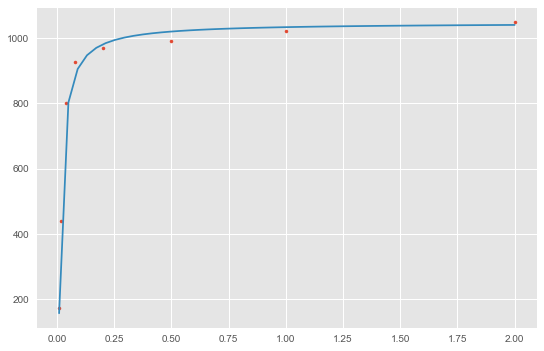

In [120]:
import scipy.optimize

popt, _ = scipy.optimize.curve_fit(
    f, i, v, bounds=(
        (0, 0, -np.inf), 
        (np.inf, np.inf, np.inf)
    ),
)

x = np.linspace(min(i), max(i))

pyplot.plot(
    i, v, '.',
    x, f(x, *popt)
)

## Arctan model

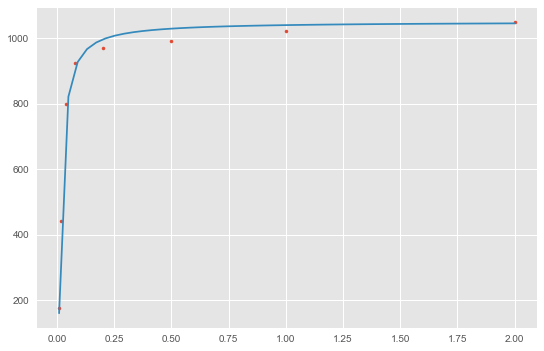

In [126]:
import scipy.optimize

f = lambda x, a, b, c: a * np.arctan(b * (x - c))
popt, pcov = scipy.optimize.curve_fit(
    f, i, v, 
    bounds=(
        # For a=1, limit as x -> infinity is pi/2. We want
        # our lower bound to be at least the max y.
        [max(v) / np.pi * 2, 0, 0], np.inf)
)

x = lambda: np.linspace(min(i), max(i))
y = lambda: f(x(), *popt)

pyplot.plot(
    i, v, '.',
    # np.log10(i), v,
    x(), y()
    # np.log10(x()), y()
)

# Comparing fit on test data



In [123]:
data = [
    # EAAY C196 data 2S1-2S5
    [[0.01, 0.02, 0.04, 0.08, 0.2, 0.5, 1.0, 2.0],
     [175, 440, 800, 925, 970, 990, 1020, 1050]],
    # Marvisfield =EA02-T03 (A496) mag curve data from old scanned test report.
    [[0.01, 0.02, 0.04, 0.08, 0.2, 0.5, 1.0, 2.0],
     [150, 340, 800, 925, 975, 1000, 1020, 1040]],

    [[0.075, .15, .2, .4, .8, 1, 2, 3, 5],
     [240, 480, 490, 530, 550, 555, 570, 580, 590]],

    [[.03, .05, .1, .15, .2, .3, .4, .5, .6, .8, .9, 1, 1.5, 2, 2.5, 3],
     [95, 194, 370, 420, 442, 465, 475, 478, 482, 489, 492, 495, 500, 509, 511, 514]],
]

In [125]:
f = lambda x, a, b, c: a * np.arctan(b * (x - c))

def plot_fit(f, i, v):
    popt, _ = scipy.optimize.curve_fit(
        f, i, v, 
        bounds=(
            # For a=1, limit as x -> infinity is pi/2. We want
            # our lower bound to be at least the max y.
            [max(v) / np.pi * 2, 0, 0], np.inf)
    )

    x = np.linspace(min(i), max(i))

    pyplot.plot(
        i, v, 'o',
        x, f(x, *popt)
    )

In [131]:
data_iter = iter(data)

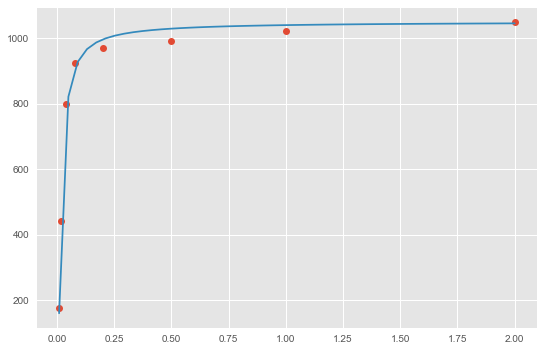

In [132]:
plot_fit(f, *next(data_iter))

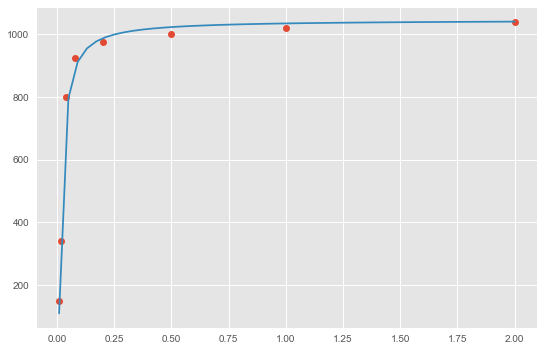

In [133]:
plot_fit(f, *next(data_iter))

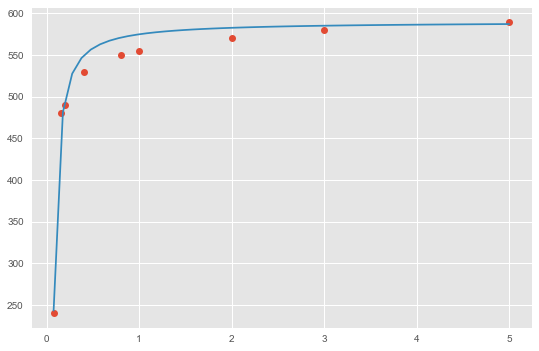

In [134]:
plot_fit(f, *next(data_iter))

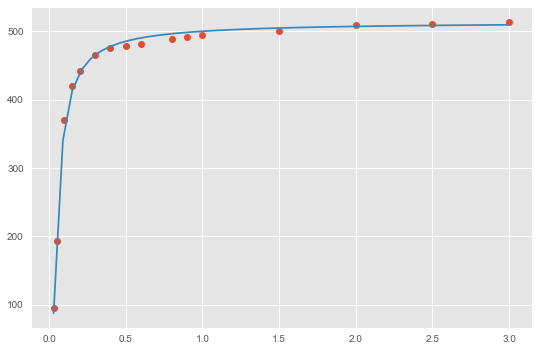

In [135]:
plot_fit(f, *next(data_iter))

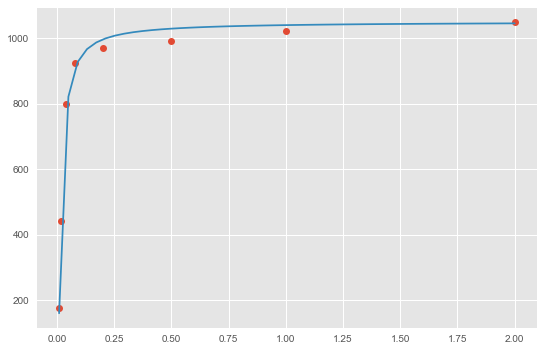

In [129]:
plot_fit(f, *next(data_iter))

In [98]:
# Marvisfield =EA02-T03 (A496) mag curve data from old scanned test report.
# i = 0.01, 0.02, 0.04, 0.08, 0.2, 0.5, 1.0, 2.0
# v = 150, 340, 800, 925, 975, 1000, 1020, 1040

# i = 0.075, .15, .2, .4, .8, 1, 2, 3, 5
# v = 240, 480, 490, 530, 550, 555, 570, 580, 590

# i = .03, .05, .1, .15, .2, .3, .4, .5, .6, .8, .9, 1, 1.5, 2, 2.5, 3
# v = 95, 194, 370, 420, 442, 465, 475, 478, 482, 489, 492, 495, 500, 509, 511, 514

In [1]:
from scipy.optimize import brentq
from j import PchipInterpolator
%matplotlib inline
rcParams['figure.figsize'] = 10, 6
plt.style.use('ggplot')

Plot test data and interpolated values.

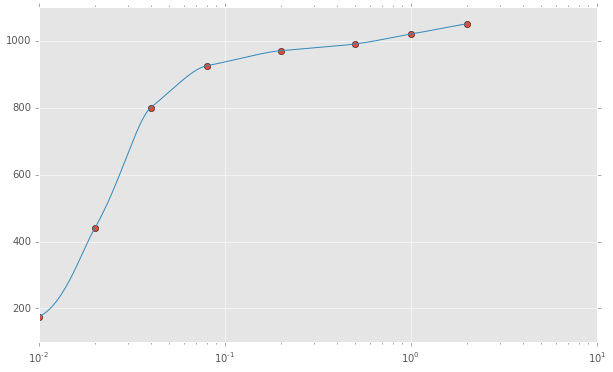

In [3]:
# Convert input tuples to numpy arrays.
i_test = np.array(i_test, dtype='float')
v_test = np.array(v_test, dtype='float')

# Create an interpolator from test data that returns interpolated voltages. 
interp_v = PchipInterpolator(i_test, v_test)
# Log-spaced  current values between first and last test data points.
i = logspace(log10(i_test[0]), log10(i_test[-1]), num=500)
v = interp_v(i)

# Plot the test data points and interpolated values.
plot(i_test, v_test, 'o')
plot(i, v)
xscale('log')

## Finding the knee point

The graph of $V(I)$ above shows the relationship between RMS voltage ($V$) and RMS magnetising current ($I$) from interpolated test data.

According to the IEC definition, the knee point voltage is the point at which a 10&nbsp;% increase in voltage requires a 50&nbsp;% increase in magnetising current.  Thus, the knee point voltage occurs at $I$ where $\frac{V(1.5 I)}{V(I)} = 1.1$. 

The knee point can be found by solving the roots of the equation $\frac{V(1.5 I)}{V(I)} - 1.1 = 0$. This will find the knee point voltage, but could also possibly find the ankle point voltage. The ankle point voltage needs to be discarded as a valid result.

Observing the graph of $V(I)$, it can be seen that the knee point voltage occurs in a region where the rate of change of voltage is decreasing. That is, where the second derivative of $V(I)$ is less than zero ($\frac{d^2V}{dI^2} < 0$). The ankle point voltage occurs in a region where the rate of change of voltage is increasing. That is, where the second derivative of $V(I)$ is greater than zero ($\frac{d^2V}{dI^2} > 0$). 

The knee point can be found by solving the roots of $\frac{V(1.5 I)}{V(I)} - 1.1 = 0$ for values of $I$ that satisfy $\frac{d^2V}{dI^2} < 0$.

### Knee point equation 

Plot the equation $\frac{V(1.5 I)}{V(I)} - 1.1 = 0$.

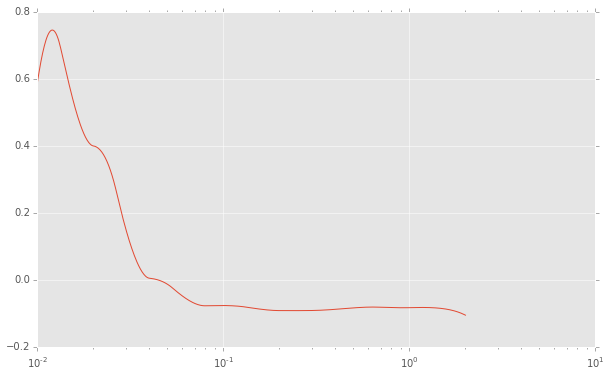

In [4]:
# Define and plot the knee point equation.
knee_point_eq = lambda i: interp_v(1.5 * i) / interp_v(i) - 1.1
knee_point_eq_vals = knee_point_eq(i)
plot(i, knee_point_eq_vals)
xscale('log')

### Second derivative of $V(I)$ 

Plot $\frac{d^2V}{dI^2}$.

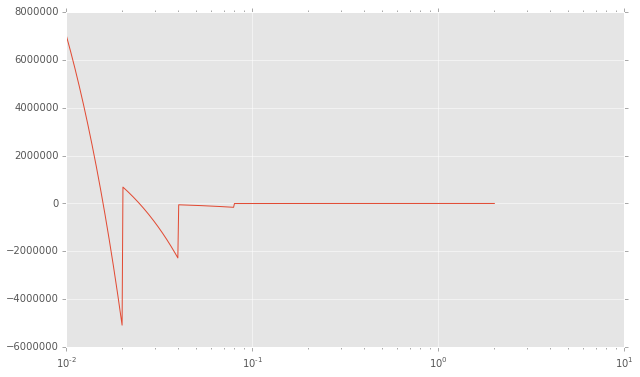

In [5]:
# Create a function that returns the second dervative of interpolated values.
d2_interp_v = interp_v.derivative(2)
d2_v = d2_interp_v(i)
plot(i, d2_v)
xscale('log')

### Valid knee point regions

Shade regions of $V(I)$ where $\frac{d^2V}{dI^2} < 0$.

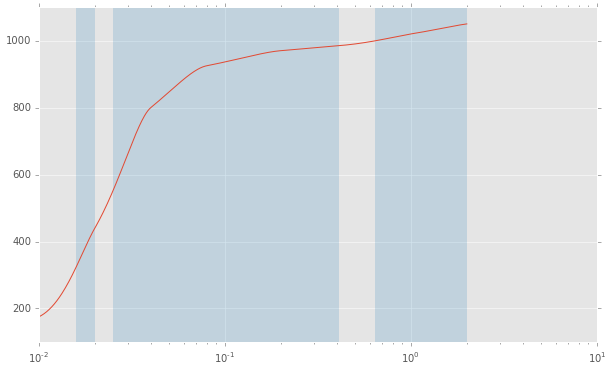

In [6]:
# Mask (mark invalid) values greater than or equal to 0.  
masked_array = ma.masked_greater_equal(d2_v, 0)
# Obtain indices of unmasked contiguous values.
slices = ma.flatnotmasked_contiguous(masked_array)
for slice in slices:
    axvspan(i[slice][0], i[slice][-1], alpha=0.2, linewidth=0)
plot(i, v)
xscale('log')

### Calculate the knee point

In [7]:
# Ranges of i where the second derivative is negative.
valid_i_ranges = (i[slice] for slice in slices)
# Intervals (start and end points) of valid ranges.
intervals = ((i_range[0], i_range[-1]) for i_range in valid_i_ranges)
# Sign changing intervals of the knee point equation. 
sign_changing_intervals = (
    (start, end) for start, end in intervals 
    if sign(knee_point_eq(start)) != sign(knee_point_eq(end))
)
# Find zeros of the knee point equation in each interval.
zeros = [brentq(knee_point_eq, start, end) for start, end in sign_changing_intervals]

# Plot if there is one and only one zero (knee point).
if len(zeros) == 1:
    i_k = zeros[0]
    v_k = np.asscalar(interp_v(i_k))

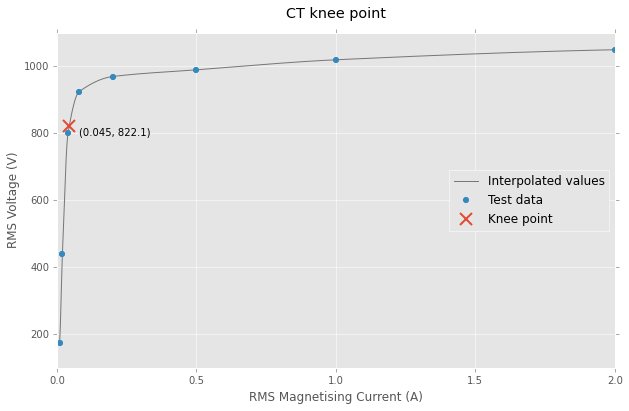

In [8]:
red, blue, purple, grey, orange, green, pink = rcParams['axes.color_cycle']
figure = plt.figure()
axes = figure.add_subplot(1, 1, 1)
axes.plot(i, v, color=grey, label='Interpolated values')
axes.plot(i_test, v_test, color=blue, marker='o', markeredgewidth=0, linewidth=0, label='Test data')
axes.plot(i_k, v_k, color=red, marker='x', markersize=12, markeredgewidth=2, linewidth=0, label='Knee point')
axes.annotate('({:.3f}, {:0.1f})'.format(i_k, v_k), (i_k, v_k), xytext=(10, -10), textcoords='offset points')
axes.set_title('CT knee point', y=1.03)
axes.set_xlabel('RMS Magnetising Current (A)')
axes.set_ylabel('RMS Voltage (V)')
axes.legend(loc='right', numpoints=1)